In [1]:
using MNIST
trainX, trainY = traindata()
trainX = (trainX - mean(trainX))/var(trainX);

In [2]:
#params
d = 784
n = 32
N = size(trainX)[2]

#need to get proper data... (note that this data is normalized)
data = trainX
Y = trainX

#which modes are we watching?
indexs = [1, 2, 3, 5, 12, 18, 31];

In [6]:
### Whiten the data -- i dont think this is working?!?
#Decorrelate with PCA
Ux, Sx, Vx = svd(data)
println(size(Ux),size(Sx),size(Vx))
X = transpose(Ux)*data
print(size(X))

(784,784)(784,)(60000,784)
(784,60000)

In [7]:
### SVD decomposition of covar(Y,X)
Uyx,Syx,Vyx = svd(Y*transpose(X))
println(size(Uyx),size(Syx),size(Vyx))
Syx = Syx/sqrt(N)

(784,784)(784,)(784,784)


784-element Array{Float64,1}:
 9.88505    
 2.01154    
 1.56382    
 1.35014    
 1.1614     
 0.950437   
 0.802912   
 0.640751   
 0.627811   
 0.522522   
 0.466126   
 0.454961   
 0.412286   
 ⋮          
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 8.95733e-16

In [8]:
### Initialize orthonormal weight matrices
#svd of some random matrix
#pick subset of n rows of U
R = svd(randn((784,784)))[1][1:n,:]

#???
D_a = diagm(randn(784))
D_b = diagm(randn(784))

function initweights() #eqns from saxe
    return (Uyx*D_a*transpose(R),R*D_b*Vyx) #dxn#nxd
end

A,B = initweights()
println(size(A),size(B))

(784,32)(32,784)


In [9]:
### now let's train it
#params
η = 0.5e-3;
T = 500 #number of train steps
t = linspace(0,T-1,T)
batch_size = 200;

In [10]:
using ReverseDiffSource

function train(func,Lossfn)
    A,B = initweights()
    modes = zeros((n,T))
    
    input = X[:,1]
    dLdW = rdiff(Lossfn, (A,B,input), ignore=[:input]);

    for i in 1:(T*10)
        if i%10 == 0
            U,S,V = svd(func(A,B,X[:,rand(1:N,batch_size*10)]))#this is expensive!!
            modes[1:n,i/10] = S[1:n]
        end

        #grad descent -- am i supposed to be doing this with batches?
        dA,dB = dLdW(A,B,X[:,rand(1:N,batch_size)])[2:4]
        A -= η*dA
        B -= η*dB
    end
    return modes, A, B
end

train (generic function with 1 method)

In [11]:
using PyPlot
xkcd();

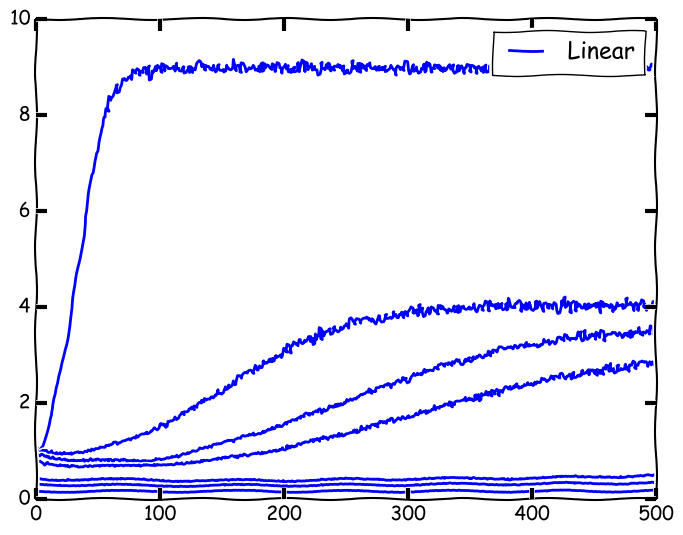

 in depwarn at deprecated.jl:73
 in to_index at deprecated.jl:447
 in setindex! at abstractarray.jl:592
 in train at In[10]:13
 in include_string at loading.jl:282
 in execute_request_0x535c5df2 at /Users/act65/.julia/v0.4/IJulia/src/execute_request.jl:183
 in eventloop at /Users/act65/.julia/v0.4/IJulia/src/IJulia.jl:143
 in anonymous at task.jl:447
while loading In[12], in expression starting on line 11


PyObject <matplotlib.legend.Legend object at 0x3140cd2e8>

In [12]:
### Linear
function LinearAE(A,B,x)
    return A*B*x
end

function LinearLoss(A,B,x)
    sum(((x-A*B*x)).^2)
end

#plot modes
linearmodes,linA,linB = train(LinearAE,LinearLoss)
for i in indexs
    plot(t,reshape(linearmodes[i,:],T),c="blue")
end
legend(["Linear"])

In [13]:
# #a test image
# figure()
# imshow(reshape(LinearAE(linA,linB,X[:,1]),(28,28)),cmap="Greys",interpolation="nearest")

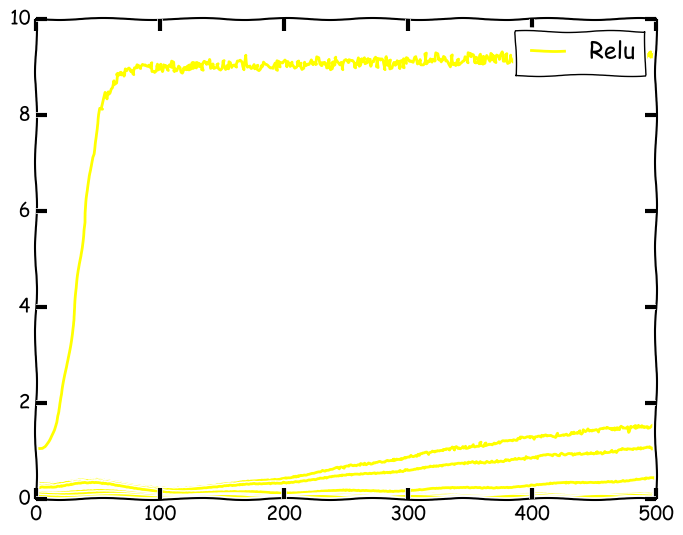

PyObject <matplotlib.legend.Legend object at 0x31421fa90>

In [14]:
### Non-linear -- Rectifier
function reluAE(A,B,x) 
    z1 = B*x
    z2 = A*max(0,z1)
    return max(0,z2)
end

function reluLoss(A,B,x) 
    z1 = B*x
    z2 = A*max(0,z1)
    return sum((x - max(0,z2)).^2)
end

#plot modes
reluModes,reluA,reluB = train(reluAE,reluLoss)
for i in indexs
    plot(t,reshape(reluModes[i,:],T),c="yellow")
end
legend(["Relu"])

In [15]:
# Softplus
function SoftplusAE(A,B,x)
    z1 = log(1.+e.^(B*x))
    return log(1.+e.^(A*z1))
end


function SoftplusLoss(A,B,x)
    z1 = log(1.+e.^(B*x))
    z2 = log(1.+e.^(A*z1))
    return sum((x - z2).^2)
end

SoftplusModes = train(SoftplusAE,SoftplusLoss)
for i in indexs
    plot(t,reshape(SoftplusModes[i,:],T),c="green")
end
legend(["Softplus"])
#numerical issues?

LoadError: LoadError: MethodError: `getindex` has no method matching getindex(::Tuple{Array{Float64,2},Array{Float64,2},Array{Float64,2}}, ::Int64, ::Colon)
Closest candidates are:
  getindex(::Tuple, ::Int64)
  getindex(::Tuple, ::Real)
  getindex(::Tuple, !Matched::AbstractArray{Bool,N})
  ...
while loading In[15], in expression starting on line 15

In [16]:
# ELU


# Maxout (?)

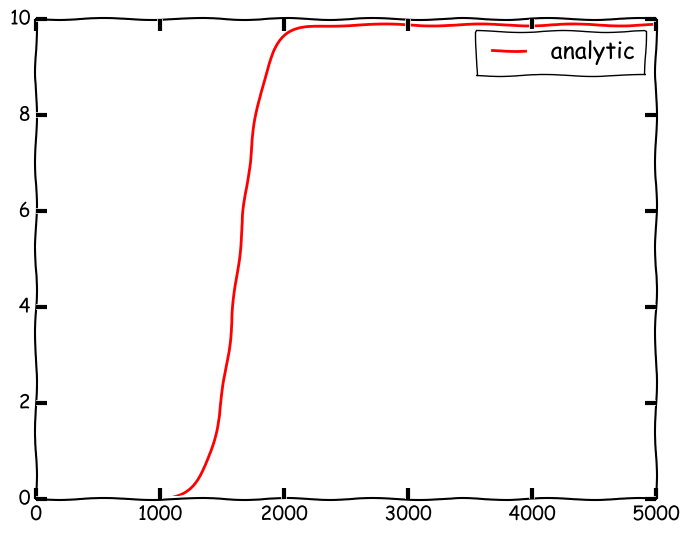

PyObject <matplotlib.legend.Legend object at 0x314e1a748>

In [19]:
### Analytic
t = linspace(0,(T-1)*10,T)
f(t,tau,s,u0) = s*exp(2*s.*t/tau)./(exp(2*s.*t./tau) - 1 + s/u0)
for i in indexs
    plot(t,f(t,1/η,Syx[i],1e-6),c="red")
end
legend(["analytic"])